In [52]:
import time


import pandas as pd
import numpy as np
import os
from brick import Brick
from astropy.io import fits
import healpy as hp


### Working on extracting the first systematic from the dataset -  stellar Density

Data use: We create a catalog of stars from DECaLS by selecting objects lying in the stellar locus (using the color cut 17 < r < 18) with PSF morphology.

Information on a per brick basis

In [53]:
hdulistBricksSouthSummary = fits.open('../bricks_data/survey-bricks-dr9-south.fits')
data_south = hdulistBricksSouthSummary[1].data
brickname_south = data_south.field('brickname')
brickid_south = data_south.field('brickid')
south_survey_is_south = data_south.field('survey_primary')

hdulistBricksNorthSummary = fits.open('../bricks_data/survey-bricks-dr9-north.fits')
data_north = hdulistBricksNorthSummary[1].data
brickname_north = data_north.field('brickname')
brickid_north = data_north.field('brickid')
survey_north = data_north.field('survey_primary')
north_survey_is_south = np.invert(survey_north)

In [65]:
print()
print("=============================== Classification Stellar Density... ==================================")
print()

start = time.time()

bricknames_south_sample = []

for filename in os.listdir('/Volumes/Astrostick/bricks_data/south/'):
    brickn = filename.replace("tractor-", "")
    brickn = brickn.replace(".fits", "")
    bricknames_south_sample.append(brickn)

bricknames_south_sample.pop()
df = pd.DataFrame(columns=['RA', 'DEC'])

for no, brickname in enumerate(bricknames_south_sample):
    hdulistSingleBrick = fits.open(f'/Volumes/Astrostick/bricks_data/south/tractor-{brickname}.fits')
    data = hdulistSingleBrick[1].data

    brick = Brick(data)
    ra = data.field('ra')
    dec = data.field('dec')

    brick.initialise_brick_for_stellar_density()

    # Extracting Positions, and Object IDs

    stellar_density = brick.get_stellar_objects()

    # Process array
    stacked_array = np.stack(( ra, dec, stellar_density), axis=1)
    support_df = pd.DataFrame(stacked_array, columns=['RA', 'DEC', 'Target_type'])
    support_df.drop(support_df[support_df.Target_type == 0].index, inplace=True)
    support_df.drop(columns='Target_type')
    df = df.append(support_df)

print()
print("=============================== Classification Stellar Completed ==================================")
print()
df = df[df['Target_type'] > 0]
df.to_csv('../bricks_data/galaxy_catalogue_stellar.csv', index=False)
print(df.shape)
print(df.head())

print("Time taken for ", len(bricknames_south_sample), " bricks: ", time.time() - start)


=============================== Classification Stellar Density... ==================================


=============================== Classification Stellar Completed ==================================

(3124201, 3)
            RA        DEC  Target_type
5   244.243524  25.702826          1.0
6   244.243586  25.672268          1.0
9   244.244017  25.725197          1.0
10  244.244051  25.638908          1.0
12  244.244126  25.700132          1.0
Time taken for  1051  bricks:  918.7811138629913


In [66]:
df = pd.read_csv('../bricks_data/galaxy_catalogue_stellar.csv')

duplicates_removed = df.drop_duplicates()

duplicates_removed.to_csv('../bricks_data/galaxy_catalogue_stellar.csv', index=False)


# Setting NSIDE values
NSIDE = 256
NPIX = hp.nside2npix(NSIDE)
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        NSIDE, hp.nside2resol(NSIDE, arcmin=True) / 60
    )
)

Approximate resolution at NSIDE 256 is 0.23 deg


In [67]:
def raDec2thetaPhi(ra, dec):
    return (0.5 * np.pi - np.deg2rad(dec)), (np.deg2rad(ra))

Number of stellar objects in Sample: 3124201
Mean stellar objects per Pixel: 574.3016544117647


/Users/edgareggert/miniconda3/envs/astro/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/Users/edgareggert/miniconda3/envs/astro/lib/python3.8/site-packages/healpy/projaxes.py:541: UserWarning: 0.0 180.0 -180.0 180.0
  warnings.warn(
/Users/edgareggert/miniconda3/envs/astro/lib/python3.8/site-packages/healpy/projaxes.py:656: UserWarning: The interval between parallels is 30 deg -0.00'.
  warnings.warn(
/Users/edgareggert/miniconda3/envs/astro/lib/python3.8/site-packages/healpy/projaxes.py:664: UserWarning: The interval between meridians is 30 deg -0.00'.
  warnings.warn(


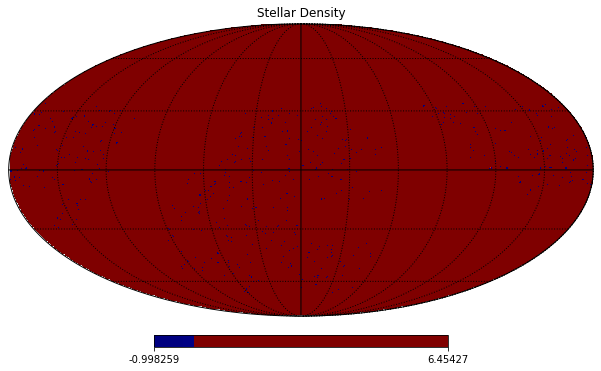

In [68]:
ra = df["RA"].to_numpy(copy=True)
dec = df["DEC"].to_numpy(copy=True)

theta, phi = raDec2thetaPhi(ra, dec)

print("Number of stellar objects in Sample:", len(ra))

m = np.zeros(NPIX)
pixel_indices = hp.ang2pix(NSIDE, theta,phi)

# Finding out unique indices and how often they appear --> shows the density of LRGs in this pixel
(unique, counts) = np.unique(pixel_indices, return_counts=True)

mean = counts.mean()
print("Mean stellar objects per Pixel:", mean)
# Calculating Densities for every block
density = (counts / mean) - 1

m[unique] = density
hp.mollview(m, title="Stellar Density", norm="hist",cmap="jet")
hp.graticule()